### Importing COCO data

In [10]:
%load_ext autoreload
%autoreload 2

from os.path import join
import pickle as pkl
from datetime import date

import numpy as np
from keras.models import load_model
from matplotlib import pyplot as plt
from pycocotools.coco import COCO

from core_analysis.preprocess import get_image, generate_batches, unbox
from core_analysis.utils.transform import adjust_rgb, undersample
from core_analysis.utils.visualize import plot_masks, plot_image_and_mask, plot_image_with_mask

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set directory

In [11]:
LABEL_FOLDER = join("data", "json_files")
FILE = "labels_20230703.json"
CHECKPOINT_DIR = join("data", "models", "background_seg")
CHECKPOINT_FILENAME = "resnet_unet_weights_rm_bkground_20230607.h5"
DIM = (128, 128, 3)  # Shape of patches.
USE_CATS = [0, 1, 2]
N_SAMPLES = 900
MAX_IT = 1e5
N_PATCHES = 10

In [12]:
coco = COCO(join(LABEL_FOLDER, FILE))

# Get list of `category_ids`.
cat_ids = coco.getCatIds()
print("ids: ", cat_ids)
cat_names = [cat["name"] for cat in coco.loadCats(cat_ids)]
print("names:", cat_names)

# Get list of images that contain annotations.
ids = []
for cid in cat_ids:
    ids += coco.getImgIds(catIds=cid)

image_ids = np.unique(ids)
image_ids = list(image_ids)
# image_ids.remove(2)
# image_ids.remove(5)
# image_ids.remove(219)
print(image_ids)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
ids:  [1, 2, 3]
names: ['FRACTURES', 'VEINS', 'REALGAR']
[5, 18, 20, 26, 39, 40, 42, 44, 48, 55, 60, 61, 64, 67, 68, 76, 77, 81, 82, 83, 86, 87, 88, 89, 90, 91]


Image ID: 26


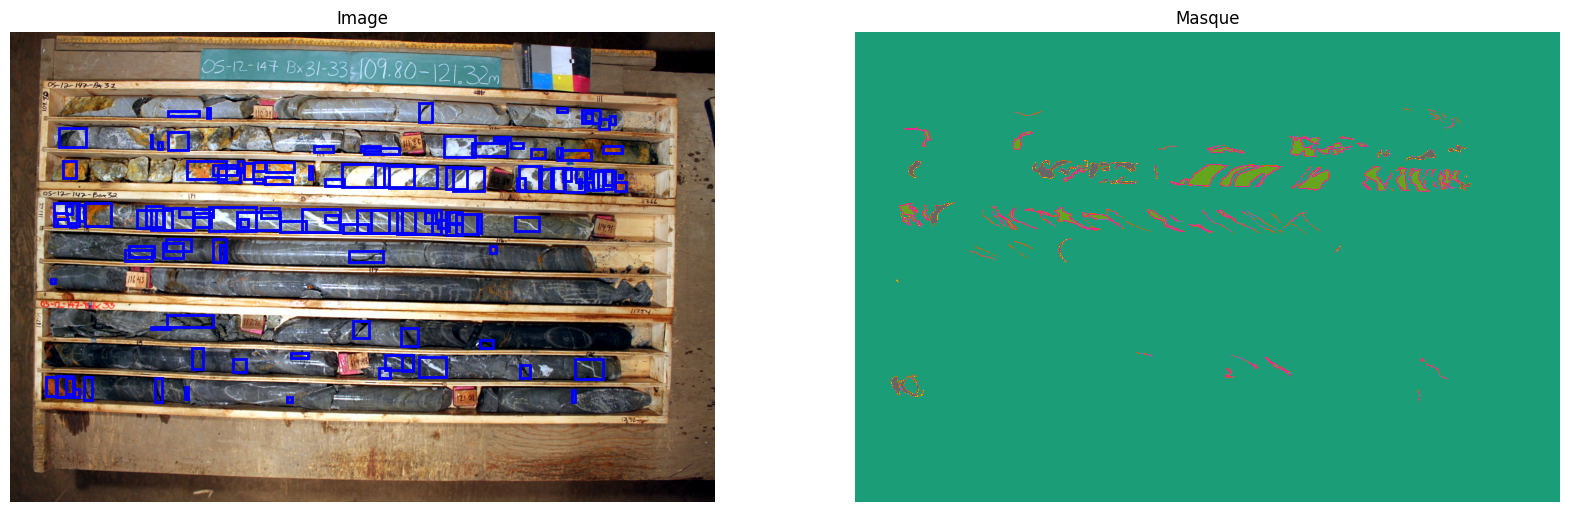

In [13]:
image, mask = plot_image_and_mask(coco, cat_ids, image_ids)

c:\Users\Travail\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


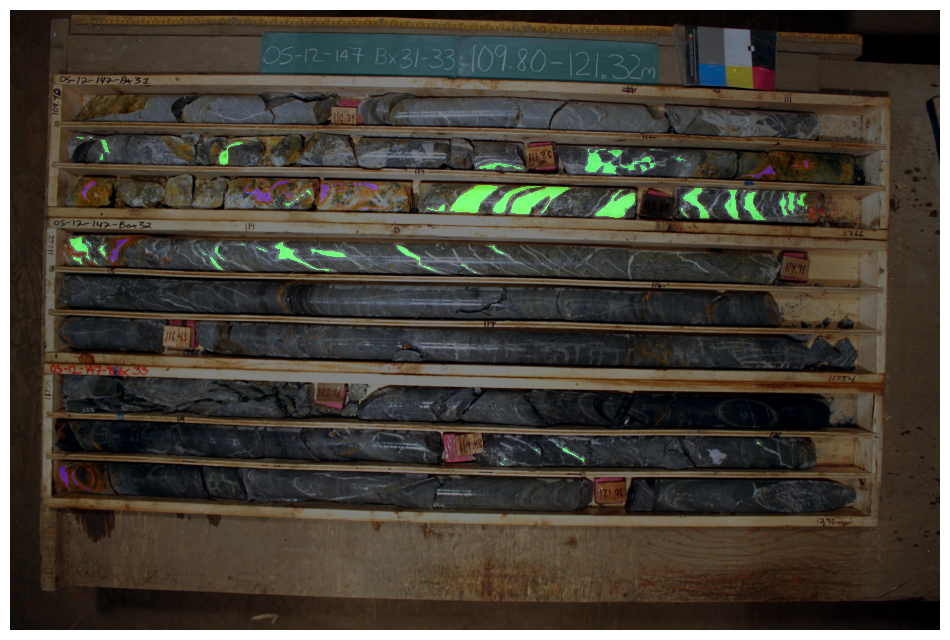

In [14]:
plot_image_with_mask(image, mask)

In [ ]:
uimage, umask = undersample(image, mask, undersample_by=2)

X, Ym, y = generate_batches(
    uimage, umask, DIM, patch_num=N_PATCHES, min_dist_to_sample=32
)

In [ ]:
plot_masks(X, Ym, cat_names)

### Generate datasets

In [ ]:
for i in range(2):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    ax[0].imshow(X[i], vmin=0.0, vmax=1.0)
    ax[1].imshow(np.rot90(np.rot90(X[i])), vmin=0.0, vmax=1.0)
    ax[0].axis("off")
    ax[1].axis("off")

    plt.savefig(
        join("data", "plots", f"data_augmentation_{i}.png"),
        dpi=300,
        bbox_inches="tight",
    )

In [ ]:
model = load_model(join(CHECKPOINT_DIR, CHECKPOINT_FILENAME), compile=False)

In [ ]:
Xtrain = []
mtrain = []
ytrain = []

Xtest = []
mtest = []
ytest = []

counts = np.unique(np.concatenate([[0, 1, 2]]), return_counts=True)[1]

i = 0
pick_id = image_ids * 3
while counts.min() < N_SAMPLES:
    # Training.
    if i < len(image_ids):
        print(
            f"\r iteration {i} / img-id {image_ids[i]} / {counts.min()*100/N_SAMPLES:.2f}%"
        )

        m = np.min(counts)
        under_samp = np.random.choice([1, 2, 4])
        image, mask, anns = get_image(coco, image_ids[i], USE_CATS, folder="images")
        image = unbox(model, image, DIM)
        image, mask = undersample(image, mask, undersample_by=under_samp)

        patch_num = len(anns) * 25
        X_train, Ym_train, y_train = generate_batches(
            image, mask, DIM, patch_num=int(patch_num), norm=False, min_dist_to_sample=4
        )

        Xtrain.append(X_train)
        mtrain.append(Ym_train)
        ytrain.append(y_train)
        counts = np.unique(np.concatenate(ytrain), return_counts=True)[1]
        i += 1

    if i > MAX_IT:
        break

# Test.
for img_id in image_ids[-3:]:
    if i > MAX_IT:
        break

    image, mask, anns = get_image(coco, img_id, USE_CATS, folder="images")
    image = unbox(model, image, DIM)
    X_test, Ym_test, y_test = generate_batches(
        image, mask, DIM, patch_num=len(anns) * 4, norm=False, min_dist_to_sample=4
    )

    Xtest.append(X_test)
    mtest.append(Ym_test)
    ytest.append(y_test)


Xtrain = np.concatenate(Xtrain, axis=0)
mtrain = np.concatenate(mtrain, axis=0)
ytrain = np.concatenate(ytrain)

Xtest = np.concatenate(Xtest, axis=0)
mtest = np.concatenate(mtest, axis=0)
ytest = np.concatenate(ytest)

In [ ]:
for _ in range(10):
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    ii = np.random.choice(np.arange(0, Xtrain.shape[0], 1, dtype=int))
    axs[0].imshow(adjust_rgb(Xtrain[ii], 5, 95), vmin=0, vmax=1)
    for j in range(3):
        axs[j + 1].imshow(mtrain[ii, :, :, j])
        axs[j + 1].set_title(cat_names[j])
    # plt.title((ytrain[ii][0], dict_labels[ytrain[ii][0]-1]))
    plt.axis("off")
    plt.show()

In [ ]:
ds = {}
ds["X_train"], ds["Y_train"], ds["y_train"] = Xtrain, mtrain, ytrain
ds["X_test"], ds["Y_test"], ds["y_test"] = Xtest, mtest, ytest

In [ ]:
today = str(date.today()).replace("-", "_")

with open(
    join("data", "dataset", f"dataset_forages_old_{dim[0]}x{dim[1]}_{today}.pickle"),
    "wb",
) as handle:
    pkl.dump(ds, handle, protocol=pkl.HIGHEST_PROTOCOL)